Loading galactic coordinates from /home/davendra_glade_plus_catalog/gw-hands-on-school-2025/GLADE_galactic_coords.txt
Loaded 22635077 points
Creating HEALPix map with NSIDE=256 (786432 pixels)
Total galaxies: 22635077
Occupied pixels: 671303
Computing angular power spectrum...


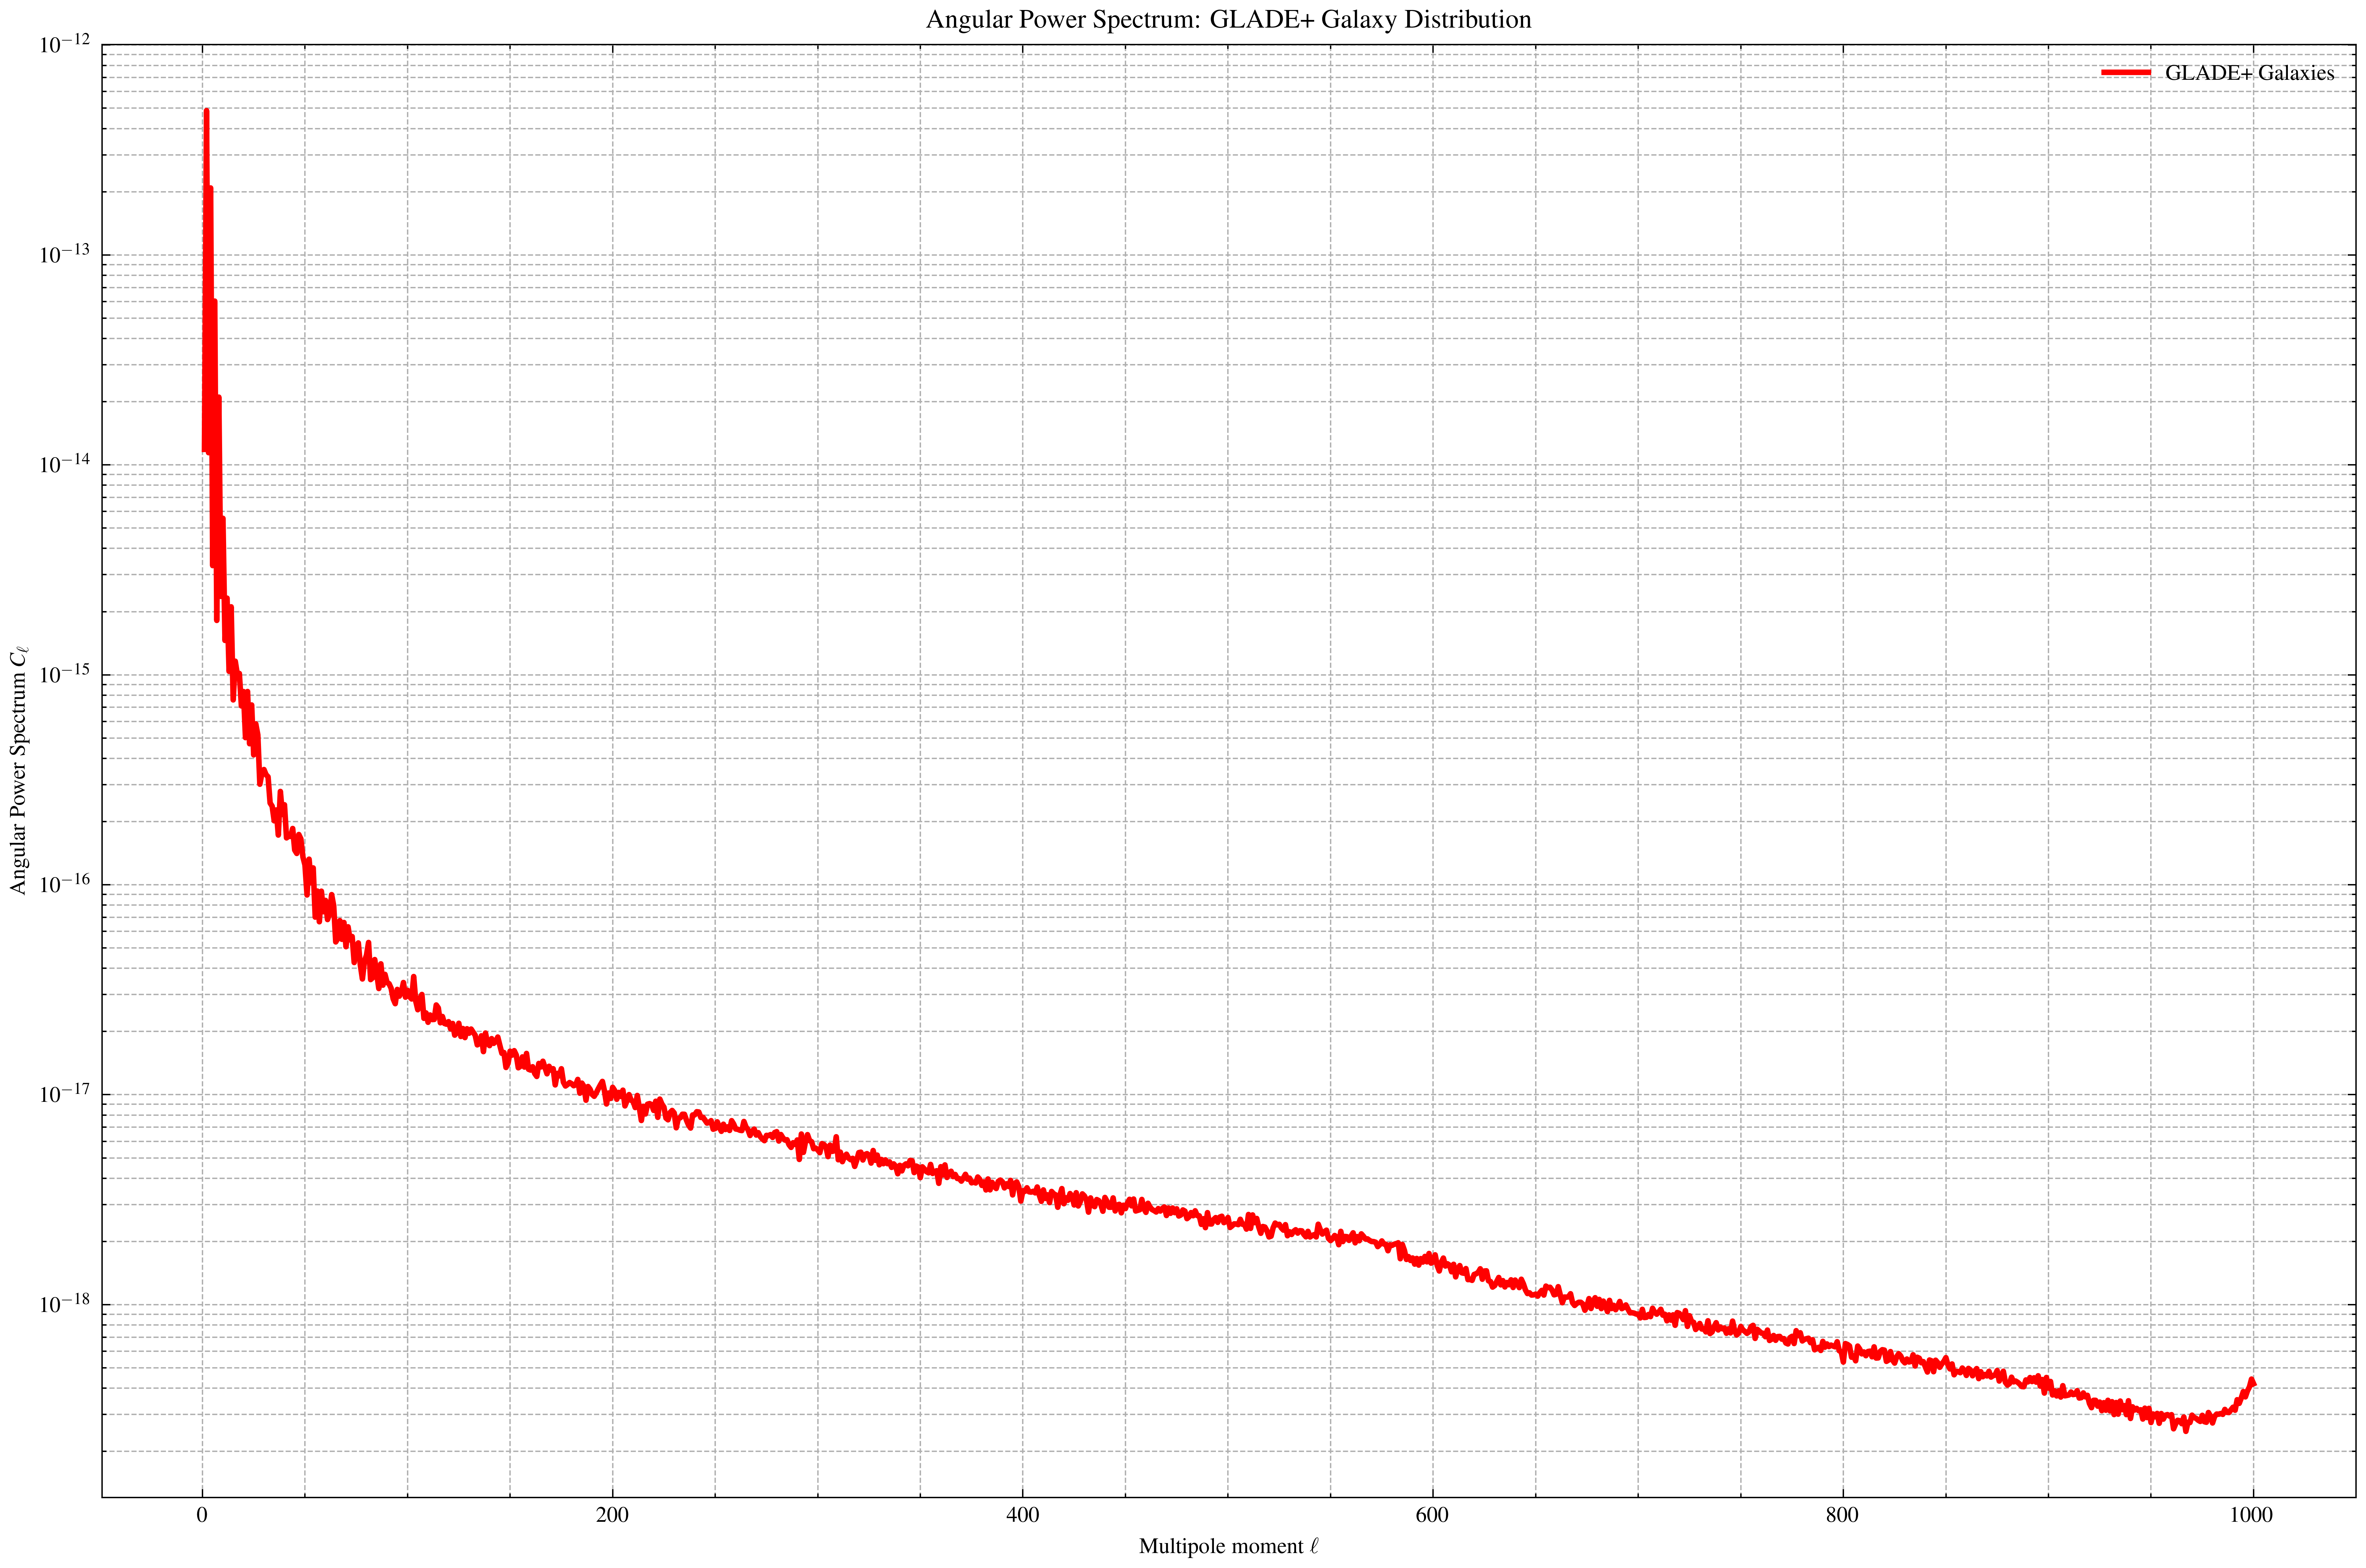

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import scienceplots

plt.style.use(['science', 'ieee','bright'])

# Parameters
NSIDE = 256  # HEALPix resolution
lmax = 1000    # Maximum multipole moment

galactic_file = "/home/davendra_glade_plus_catalog/gw-hands-on-school-2025/GLADE_galactic_coords.txt"

print(f"Loading galactic coordinates from {galactic_file}")
data = np.loadtxt(galactic_file)
l_wrapped = data[:, 0]
b_gal = data[:, 1]
z_valid = data[:, 2]
print(f"Loaded {len(l_wrapped)} points")


# Convert galactic coordinates to HEALPix format
theta_hp = np.pi/2 - b_gal  
phi_hp = l_wrapped + np.pi 
phi_hp = np.remainder(phi_hp, 2*np.pi)  # Ensure [0,2π] range

# Create HEALPix pixel indices
NPIX = hp.nside2npix(NSIDE)
pix_indices = hp.ang2pix(NSIDE, theta_hp, phi_hp)

print(f"Creating HEALPix map with NSIDE={NSIDE} ({NPIX} pixels)")

# Create galaxy density map
galaxy_map = np.zeros(NPIX)
for pix in pix_indices:
    galaxy_map[pix] += 1

# Normalize the map
galaxy_map = galaxy_map / np.sum(galaxy_map)

print(f"Total galaxies: {len(l_wrapped)}")
print(f"Occupied pixels: {np.sum(galaxy_map > 0)}")

# Compute angular power spectrum
print("Computing angular power spectrum...")
cl_galaxies = hp.anafast(galaxy_map, lmax=lmax)

# Create multipole array
ell = np.arange(lmax + 1)

# Plot angular power spectrum
plt.figure(figsize=(12, 8))

plt.plot(ell[1:], cl_galaxies[1:], 'r-', linewidth=2, label='GLADE+ Galaxies')
plt.yscale('log')
plt.xlabel(r'Multipole moment $\ell$')
plt.ylabel(r'Angular Power Spectrum $C_\ell$')
plt.title('Angular Power Spectrum: GLADE+ Galaxy Distribution')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.savefig('galaxy_power_spectrum.pdf', dpi=300, bbox_inches='tight')
plt.show()

Total galaxies: 22635077
Occupied pixels: 671303
Computing angular power spectrum...
Computing angular correlation function...


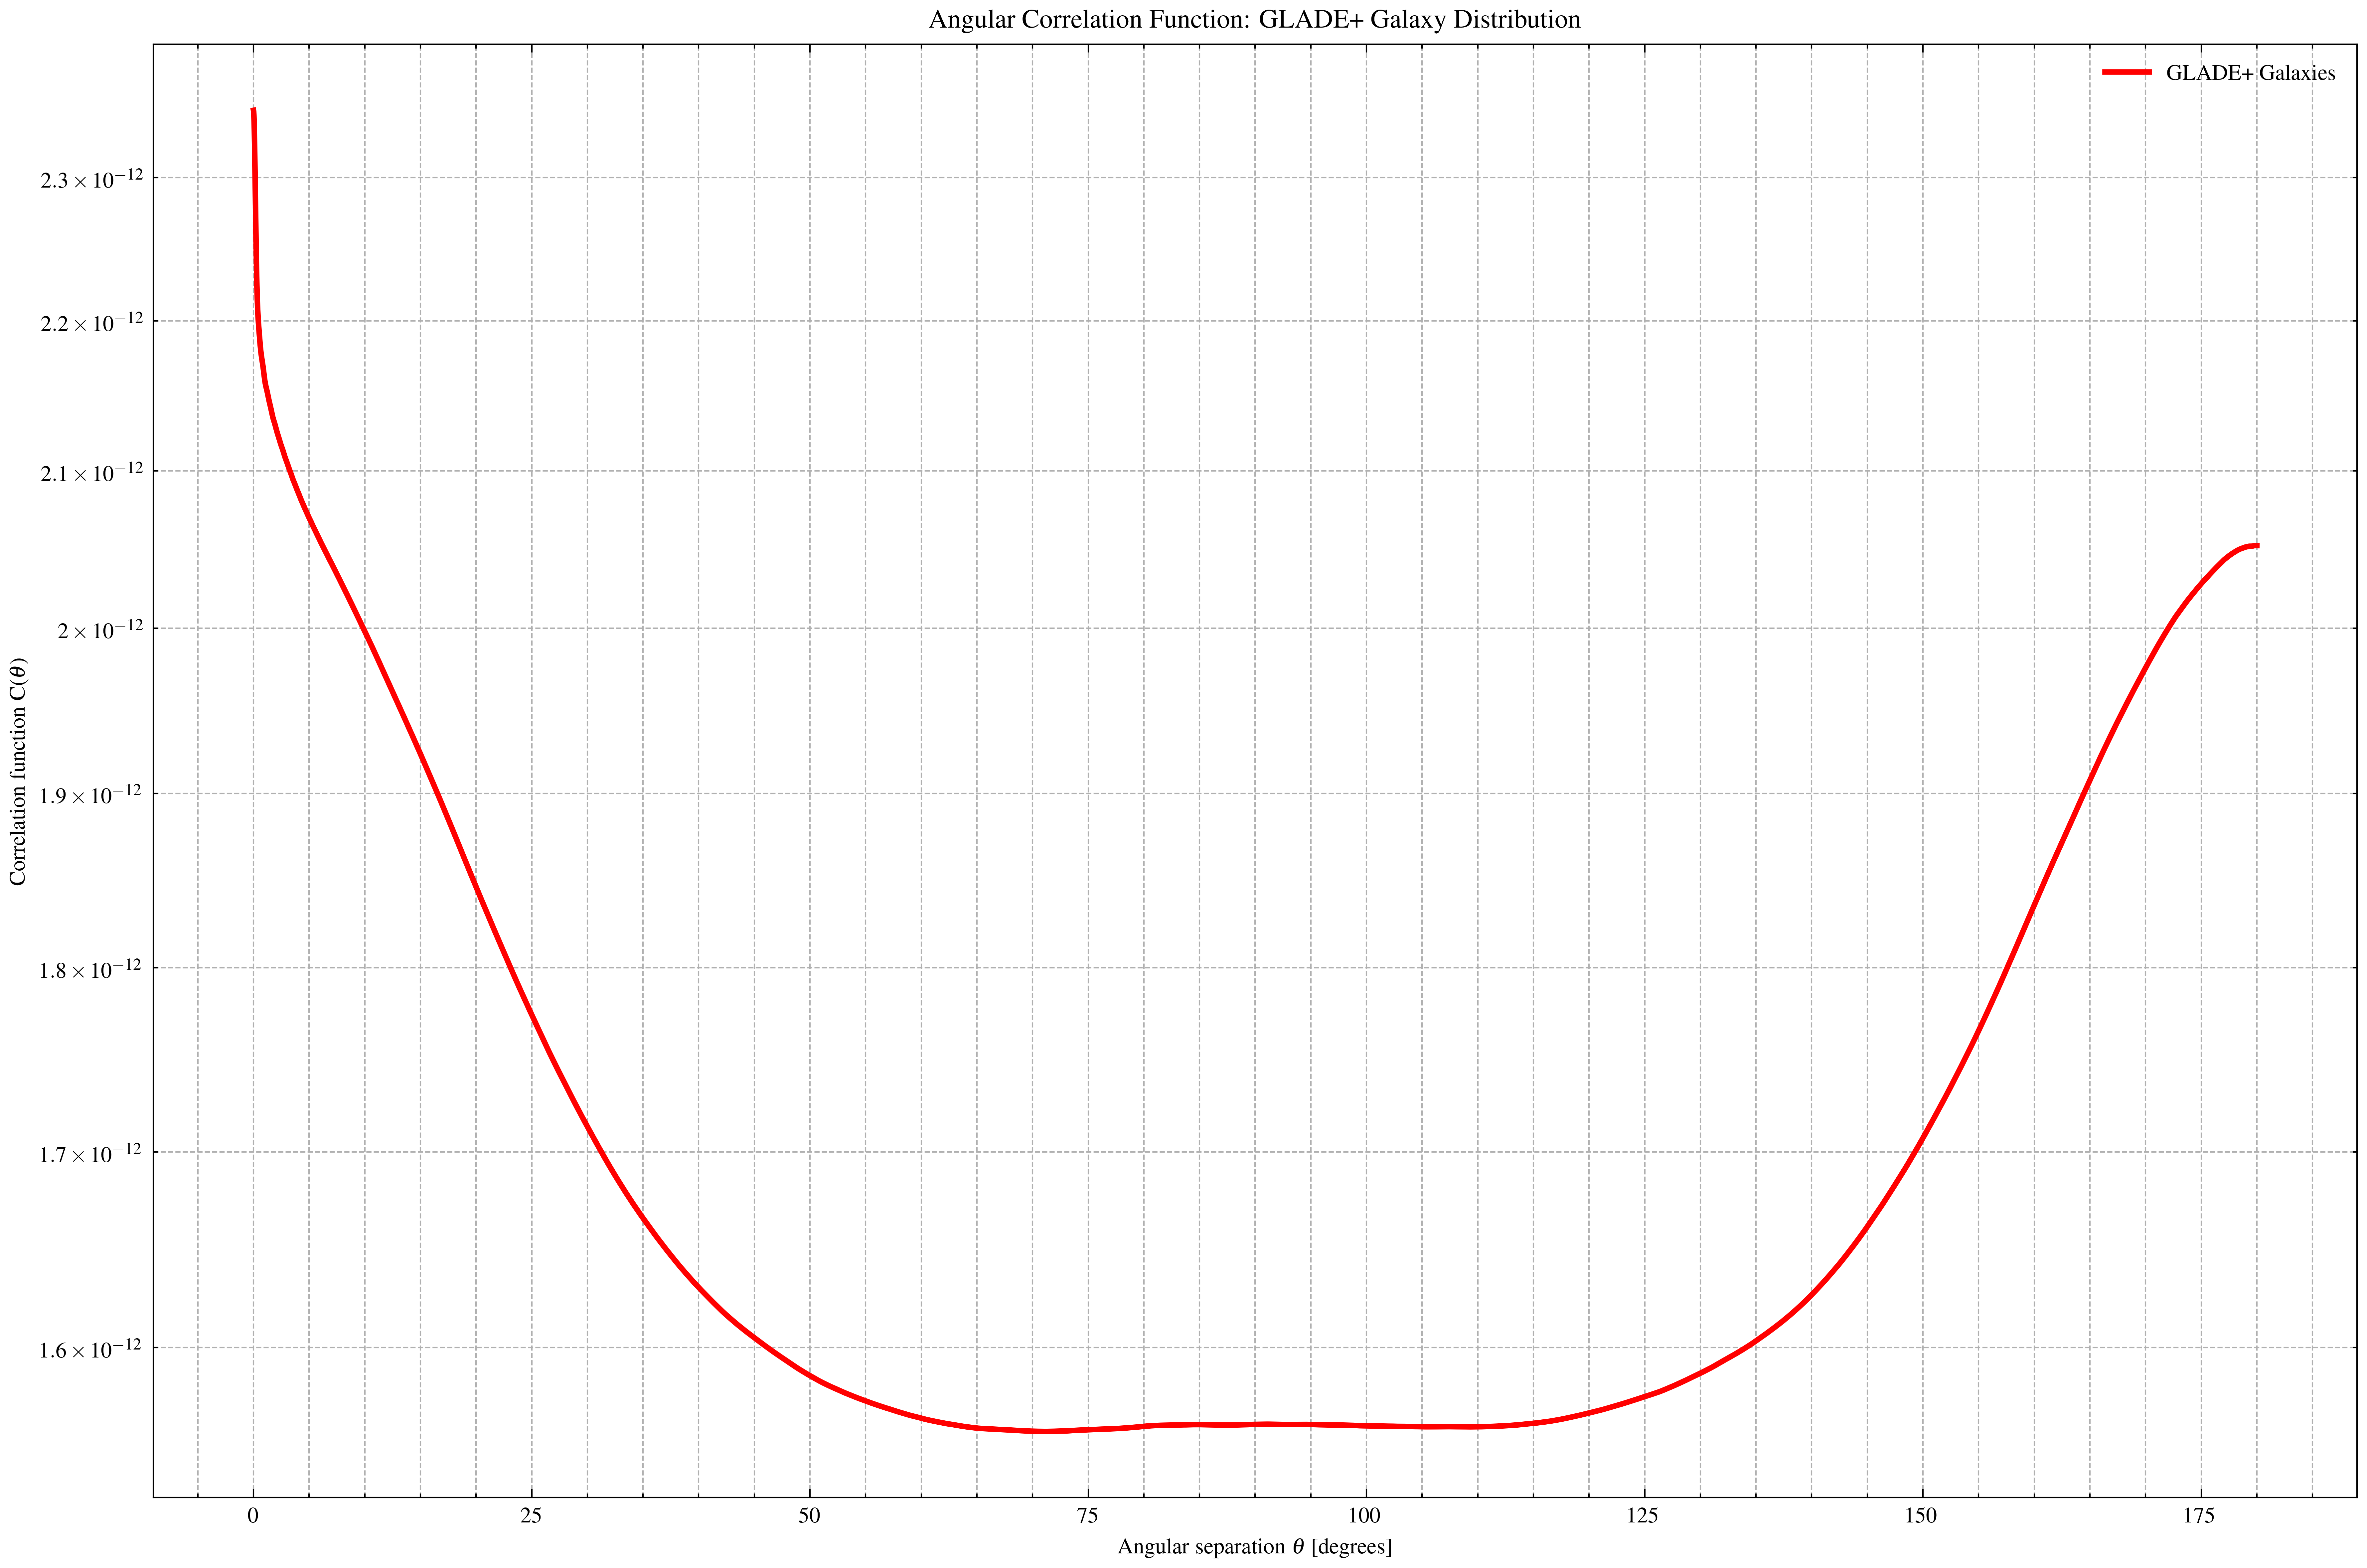

In [2]:
import healpy as hp
from scipy.special import lpmv

def compute_correlation_function(cl, theta_degrees, lmax):
    """
    Compute angular correlation function C(θ) from Cℓ.
    
    Formula: C(θ) = 1/(4π) * Σ_{ℓ=0}^{ℓmax} (2ℓ+1) Cℓ Pℓ(cos θ)
    """
    ell = np.arange(lmax + 1)
    theta_rad = np.radians(theta_degrees)
    cos_theta = np.cos(theta_rad)
    
    C_theta = np.zeros_like(theta_degrees, dtype=np.float64)
    
    for l in ell:
        # Legendre polynomial Pℓ(cos θ)
        P_l = lpmv(0, l, cos_theta)
        # Add contribution
        C_theta += (2*l + 1) * cl[l] * P_l
    
    # Normalize by 4π
    C_theta = C_theta / (4 * np.pi)
    
    return C_theta


print(f"Total galaxies: {len(l_wrapped)}")
print(f"Occupied pixels: {np.sum(galaxy_map > 0)}")

# Compute angular power spectrum
print("Computing angular power spectrum...")
cl_obs = hp.anafast(galaxy_map, lmax=lmax)

# Define theta range for correlation function 
theta_degrees = np.linspace(0.0, 180.0, 10000)
theta_degrees = np.sort(theta_degrees)

# Compute correlation function
print("Computing angular correlation function...")
C_theta_obs = compute_correlation_function(cl_obs, theta_degrees, lmax)

# Plot the angular correlation function
plt.figure(figsize=(12, 8))

plt.plot(theta_degrees, C_theta_obs, 'r-', linewidth=2, 
         label='GLADE+ Galaxies')

plt.xlabel(r'Angular separation $\theta$ [degrees]')
plt.ylabel(r'Correlation function C($\theta$)')
# plt.ylim(1e-14,1e-10) #NOTE: this may affect visual interpretation though
plt.title('Angular Correlation Function: GLADE+ Galaxy Distribution')
plt.yscale('log')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('galaxy_correlation_function.pdf', dpi=300, bbox_inches='tight')
plt.show()



In [3]:
# Create galaxy density map
galaxy_map = np.zeros(NPIX)
for pix in pix_indices:
    galaxy_map[pix] += 1

/home/davendra_glade_plus_catalog/miniconda3/envs/gw-school-2025/lib/python3.11/site-packages/healpy/visufunc.py:1630: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  ax.graticule(dpar=dpar, dmer=dmer, coord=coord, local=local, **kwds)


<Figure size 7200x4800 with 0 Axes>

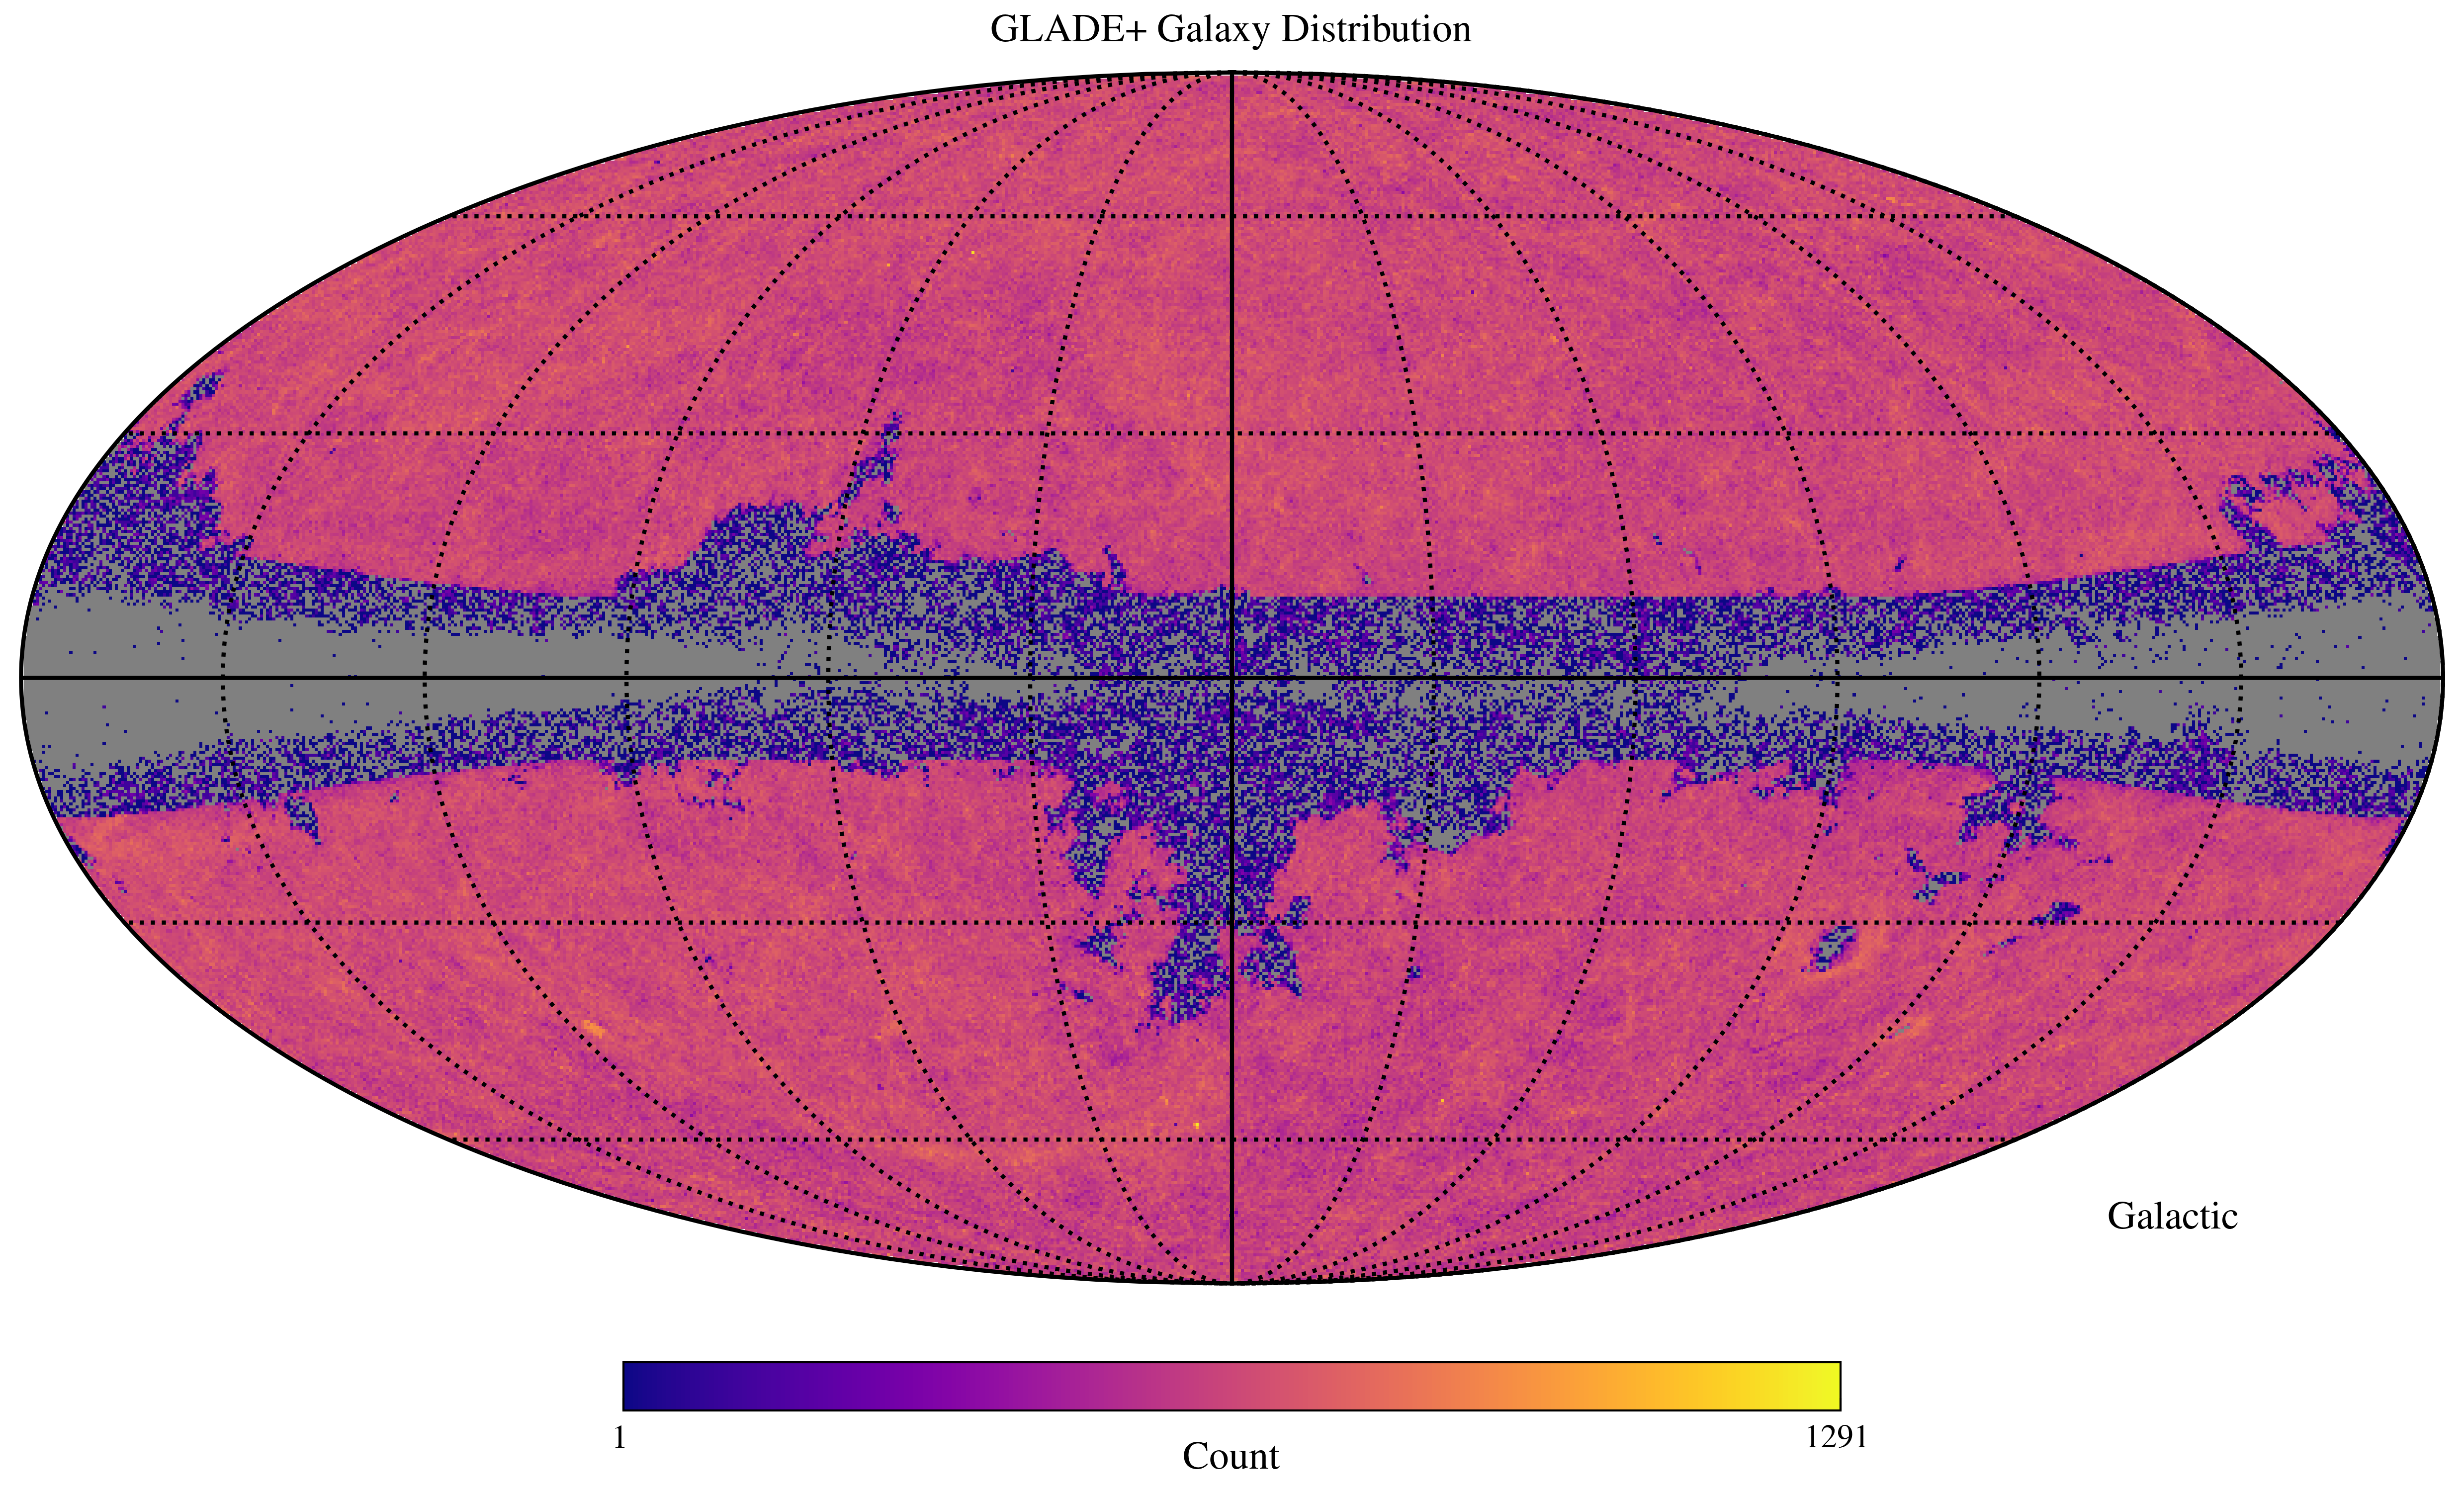

In [4]:
plt.figure(figsize=(12, 8))

hp.mollview(galaxy_map, 
            coord='G',  # Galactic coordinates
            title='GLADE+ Galaxy Distribution',
            cmap='plasma',
            norm='log',  # Log scale for better contrast
            cbar=True,
            unit='Count',
            min=galaxy_map[galaxy_map > 0].min(),  # Avoid log(0) issues
            max=galaxy_map.max())

# Add coordinate grid (30° intervals)
hp.graticule(verbose=False, dpar=30, dmer=30)

plt.savefig('galaxy_map.pdf', dpi=300, bbox_inches='tight')
plt.show()